# MICROSCOPE Session 380

In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import pyfftw
import fftwisdom
import numpy as np
from pyfftw.interfaces.numpy_fft import fft, ifft
from microspy import fileload, model, cmsread, regression, rdbin
from microspy import preprocessing
from pywer import psd
from gwavelets import matching, shapelets
from bayesdawn import datamodel
from mecm import mecm
from plottools import presets
pyfftw.interfaces.cache.enable()

### 1.Load N2 data

In [2]:
# Root path
root_path = '/Users/qbaghi/Documents/MICROSCOPE/data/session_380/N1N2/'
# Session name
session_name = 'Session_380_EPR_V3DFIS2_01_SUREF'
# Data level
data_level = 'N2a_01_L_SCA_G_0050'
# Sensor unit
su = 'SUREF'

file_path = root_path + session_name + '/' + data_level + '/' + su + '/'

# Load data
acc_d, acc_c, t, mask = fileload.load_acceleration_modes(
    file_path, axes=np.array(['X', 'Y', 'Z']), voie='sca', prefix='Acc')

### 2. Preprocessing

In [3]:
# Differential mode
n_data = acc_d.shape[0]
fs = 4.0
fep = 3.1114e-3
mask_d = np.ones(n_data)
mask_d[acc_d[:, 0] == 0] = 0
acc_d_m = (acc_d - np.mean(acc_d[mask_d == 1], axis=0))
acc_d_m = acc_d_m * np.array([mask_d]).T

mask_c = np.ones(n_data)
mask_c[acc_c[:, 0] == 0] = 0
acc_c_m = (acc_c - np.mean(acc_c[mask_c == 1, :], axis=0))
acc_c_m = acc_c_m * np.array([mask_c]).T

# # Load mask
# mask = rdbin.read(file_path + 'MaskDifN2Xscaa.bin')
# mask_d = mask._values
t = np.arange(0, n_data) / fs

### 3. Detection of glitches using sigma-clipping

In [4]:
# Sigma-clipping
mask_clip = preprocessing.sigma_clip(acc_c_m[:, 0], k=5, n_it=3, margin=5,
                                     mask_init=mask_c)
print("Discard " + str(100 * (n_data - np.sum(mask_clip)) / n_data) + " percent of data.")

Discard 2.296693501367897 percent of data.


In [5]:
f = np.fft.fftfreq(n_data) * fs
wd = np.hanning(n_data)


#### Mask periodogram

In [6]:
pmask = model.periodogram(mask_clip, wd)
idpos = np.where(f > 0)[0]

presets.plotconfig(ctype='time', lbsize=16, lgsize=14)
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[idpos], np.sqrt(pmask[idpos] / fs), color='gray')
ax1.legend(loc='upper left')
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"Mask power [$1/\sqrt{Hz}$]")
ax1.set_xlim([1e-3, 1e-2])
plt.show()

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


### 4. Build physical model in the time domain

In [7]:
# t1, gx, mask = cmsread.read_cmsm(file_path + 'Acc_gravite1.bin')
pm = model.PhysicsModel(file_path, su)
pm.loadgradients(actens=False, fileformat='bin')
# t1, gx, mask = cmsread.rdData(file_path + 'Acc_gravite1.bin')
full_mat = np.column_stack([0.5 * pm.g, pm.sxx, pm.sxz, np.ones(n_data)])
# Add polynomial trend
deg = 0
polys = np.column_stack([(t * fs) ** i for i in range(deg + 1)])
full_mat = np.hstack([full_mat, polys])  # * np.array([mask_d]).T

### 5. Analysis of a small segment lasting 20 orbits starting at the 24th orbit

In [8]:
# We work with a subset of data
ns = 2**19
# Starting at 24th orbit
forb = 1.7e-4
n_start = np.int(24 / forb * fs)
# Corresponding Indices
inds = np.arange(n_start, n_start + ns)

# Restricted sigma-clipping mask
mask = mask_clip[inds]
# Apodization windowing
w = np.hanning(ns)
# Re-scale the data to avoid numerical issues
scale = 1e-9
# Data masked with sigma-clipping
y = acc_d[inds, 0] / scale

# Data minimally masked
y0 = acc_d[inds, 0] * mask_d[inds] / scale

# Restricted model
a_mat = full_mat[inds, :]

# PSD estimation
psd_cls = psd.PSDSpline(ns, fs, n_knots=30, d=3, fmin=None, fmax=None)
# psd_cls.estimate((y0 - np.mean(y0)) * mask_d[inds], wind=w*mask_d[inds])
# s_n = psd_cls.calculate(ns)
# s_2n = psd_cls.calculate(2 * ns)

In [9]:
# Plot periodogram on restricted segment of 44 orbits
# --------------------------------------------------------------------------
f = np.fft.fftfreq(ns) * fs
idpos = np.where(f > 0)[0]
py0 = model.periodogram((y0 - np.mean(y0)) * mask_d[inds], w*mask_d[inds])
# fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
# ax1.loglog(f[idpos], np.sqrt(py0[idpos] / fs), color='black',
#            label='Analysed data')
# ax1.loglog(f[idpos], np.sqrt(s_n[idpos] / fs), color='red',
#            label='Estimated PSD')
# ax1.legend(loc='upper left')
# ax1.set_xlabel("Frequency [Hz]")
# ax1.set_ylabel("Acceleration [m/s2/sqrt{Hz}]")
# plt.show()

### 9. Run MECM

In [10]:
# MECM parameters
# Convergence criterium
tol_cg = 1e-4
# Maximum autocovariance lag for sparse approximation of the covariance
p = 60
# Maximum number of iterations of the PCG
nit_cg = 1000
# PCG algorithm to use
pcg_algo = 'scipy'
# Parameter estimation convergence criterium
eps = 1e-3
# Number of random draws for conditional periodogram estimation
nd = 1


# a0_est, a0_cov, a0_vect, y_rec, p_cond_mean, psd_cls, success = mecm.maxlike(
#     y, mask, a_matrix, n_it_max=15, eps=1e-3, p=p, nd=10, n_est=100,
#     nit_cg=nit_cg, tol_cg=tol_cg, compute_cov=True, verbose=True,
#     pcg_algo='scipy', psd_cls=None)

# Instantiate MECM class
# Intantiate ECM class
ecm = mecm.MECM(y, mask, a_mat, psd_cls, eps=eps, p=p,
                nd=nd, nit_cg=nit_cg, tol_cg=tol_cg, pcg_algo=pcg_algo, mask0=mask_d[inds])

Perform linear regression...
Complete.


<IPython.core.display.Javascript object>


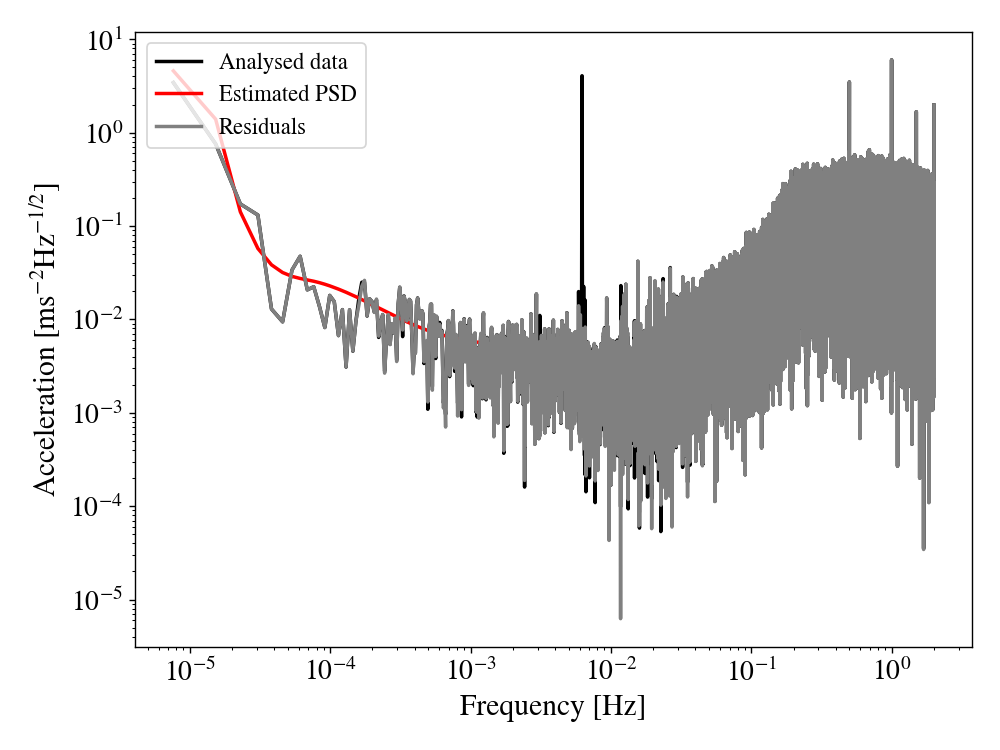

In [22]:
# Compute first residuals
p_res = model.periodogram(ecm.res, ecm.wd*ecm.mask0)
# Verify that initialization is well done
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[idpos], np.sqrt(py0[idpos] / fs), color='black',
           label='Analysed data')
ax1.loglog(f[idpos], np.sqrt(ecm.s_n[idpos] / fs), color='red', label='Estimated PSD')
ax1.loglog(f[idpos], np.sqrt(p_res[idpos] / fs), color='gray', label='Residuals')
ax1.legend(loc='upper left')
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel(r"Acceleration [$\rm ms^{-2}{Hz}^{-1/2}$]")
plt.show()

In [16]:
# Run 1 E-step
ecm.e_step()

Build preconditionner...
Preconditionner built.
successful exit!
Value of || A * x - b ||/||b|| at exit:
9.917964814048717e-05
successful exit!
Value of || A * x - b ||/||b|| at exit:
9.872669696660858e-05


In [ ]:
# Run 1 M-step

### 10. Analysing the recontructed data

<IPython.core.display.Javascript object>


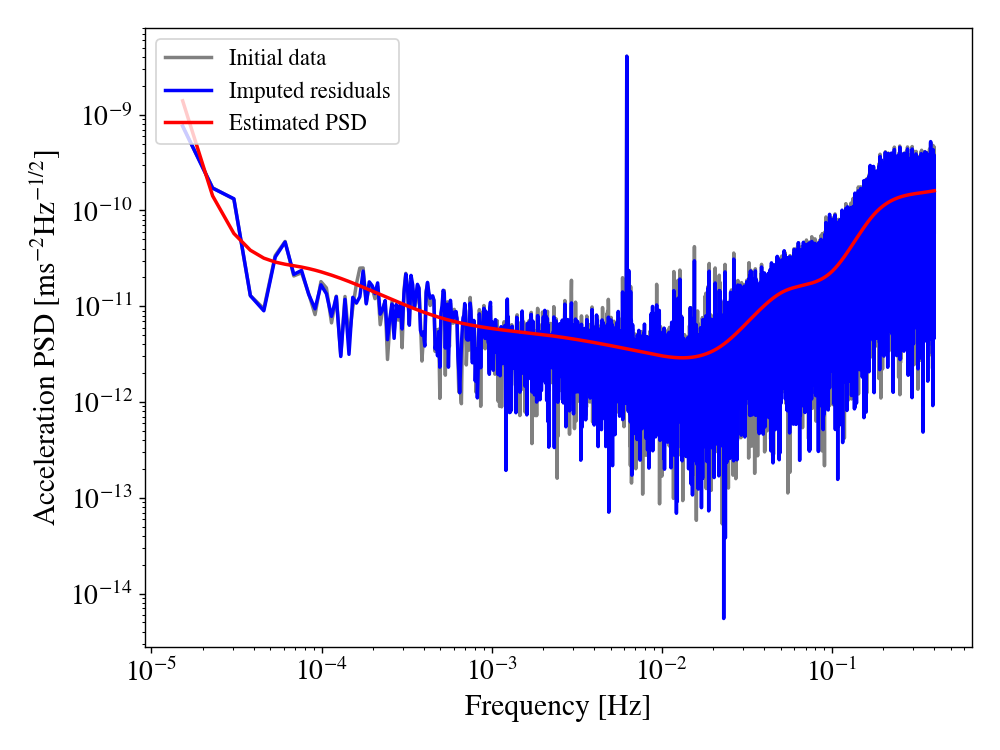

In [23]:
# Periodogram of reconstructed data
pyrec = model.periodogram(ecm.y_rec - ecm.y_rec.mean(), ecm.wd)
# Compare it with the initial, non-clipped data segment
py0 = model.periodogram((y0 - np.mean(y0)) * mask_d[inds], w*mask_d[inds])
# Restrict to frequencies around f_EP
# iep = np.where((f>2e-3) & (f<4e-3))
iep = np.where((f>1e-5) & (f<4e-1))
# Plot them
fig1, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True)
ax1.loglog(f[iep], np.sqrt(py0[iep] / fs) * scale, color='gray',
           label='Initial data')
ax1.loglog(f[iep], np.sqrt(pyrec[iep] / fs) * scale, color='blue',
           label='Imputed residuals')
ax1.loglog(f[iep], np.sqrt(ecm.s_n[iep] / fs) * scale, color='red', label='Estimated PSD')
ax1.legend(loc='upper left')
ax1.set_xlabel(r"Frequency [Hz]")
ax1.set_ylabel(r"Acceleration PSD [$\mathrm{ms^{-2}{Hz}^{-1/2}}$]")
# ax1.set_xlim([3e-3, 3.2e-3])
plt.show()
